<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_RamK_Multi_torch/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==4.8.0.76

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [2]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [3]:
import PIL
from PIL import Image

In [4]:
import cv2

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:10<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [7]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [8]:
img_folder_path = os.path.join(path, found_directories[0])
print(img_folder_path)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [10]:
try:
    num_files = len([f for f in os.listdir(img_folder_path) if os.path.isfile(os.path.join(img_folder_path, f))])
    print(f"Number of files in the dataset: {num_files}")
    for f in os.listdir(img_folder_path):
      image_path = os.path.join(img_folder_path, f)
      with Image.open(image_path) as img:
            width, height = img.size  # Get image dimensions
            print(f"{f} Image Size: {width} x {height}")  # Print the size


except FileNotFoundError:
    print(f"Error: Directory not found at '{img_folder_path}'. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Streaming output truncated to the last 5000 lines.
3159569570_dff24e7be9.jpg Image Size: 500 x 333
3591170729_406fdb74e5.jpg Image Size: 500 x 335
3159641529_c2c74f3eaf.jpg Image Size: 333 x 500
1932314876_9cc46fd054.jpg Image Size: 500 x 375
822836318_21544f0f78.jpg Image Size: 500 x 375
3294717824_3bb7b5d1c8.jpg Image Size: 400 x 500
3247168324_c45eaf734d.jpg Image Size: 500 x 375
3373544964_c9f1253b7d.jpg Image Size: 333 x 500
2665264979_df9c284bf8.jpg Image Size: 500 x 375
472661386_723aae880b.jpg Image Size: 500 x 375
1685990174_09c4fb7df8.jpg Image Size: 500 x 333
2795352290_9209b214f3.jpg Image Size: 500 x 374
3371279606_c0d0cddab2.jpg Image Size: 500 x 407
3034585889_388d6ffcc0.jpg Image Size: 500 x 336
1094462889_f9966dafa6.jpg Image Size: 500 x 375
247617754_4b1137de8c.jpg Image Size: 500 x 333
3442844140_15aa45e9b8.jpg Image Size: 500 x 334
2661489896_cc3425777e.jpg Image Size: 500 x 375
3290105461_7590f23371.jpg Image Size: 500 x 333
2394003437_184a838aa9.jpg Image Size: 37

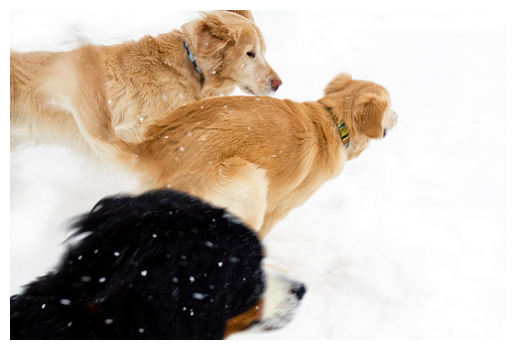

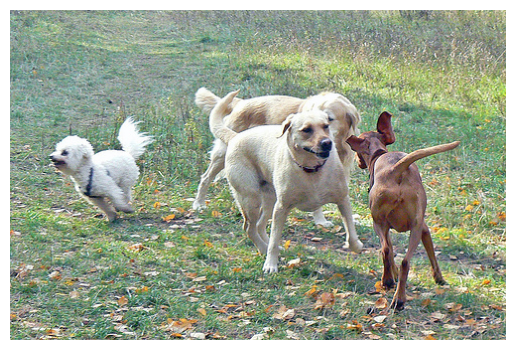

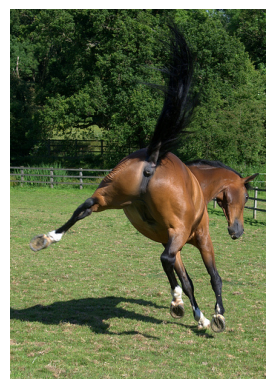

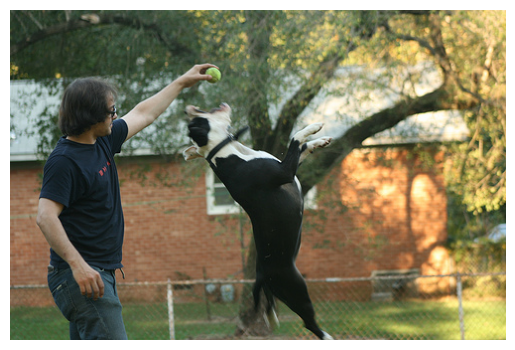

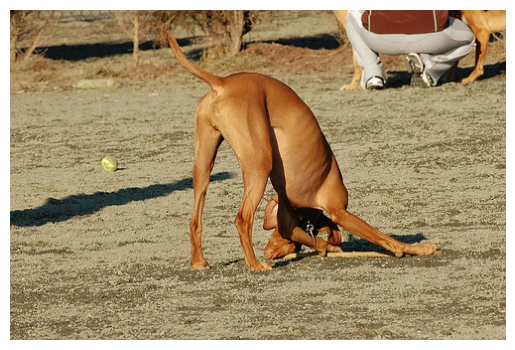

In [11]:
image_count = 0  # Initialize the count

for f in os.listdir(img_folder_path):
      if image_count >=5:
        break;
      image_path = os.path.join(img_folder_path, f)
      img = cv2.imread(image_path)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img_rgb)
      image_count += 1
      plt.axis('off')
      plt.show()


In [ ]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_path = os.path.join(self.image_dir, self.image_files[idx])

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Return the processed tensor
        return image_tensor

# Define the directory containing images
image_dir = "path_to_image_directory"  # Replace with your directory

# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Iterate over the DataLoader
for batch_idx, batch_images in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    break

In [12]:
images_dir = img_folder_path
resized_folder = os.path.join(os.getcwd(), "resized_images") # Folder for resized images
ready_folder = os.path.join(os.getcwd(), "ready_images")  # Folder for normalized images

In [13]:
# Create folders if they don't exist
os.makedirs(resized_folder, exist_ok=True)
os.makedirs(ready_folder, exist_ok=True)

In [ ]:
def preprocess_image(image_path):
    # Load the image and resize to 224x224
    image = cv2.imread(image_path)  # OpenCV reads in BGR format
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    image_resized = cv2.resize(image, (224, 224))  # Resize to 224x224

    # Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Convert to tensor: HWC -> CHW and scale pixel values
    image_tensor = np.transpose(image_rgb, (2, 0, 1))  # Convert to CxHxW
    image_tensor = torch.tensor(image_tensor, dtype=torch.float32) / 255.0  # Normalize to [0, 1]

    return image_tensor

In [14]:
# ImageNet mean and std values for VGG-16 normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [ ]:
def preprocess_image_opencv(image_path):
    # Step 1: Read the image using OpenCV
    image = cv2.imread(image_path)  # OpenCV loads in BGR format
    if image is None:
        raise ValueError(f"Image not found at {image_path}")

    # Step 2: Resize the image to 224x224 using OpenCV
    image_resized = cv2.resize(image, (224, 224))

    # Step 3: Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Step 4: Normalize pixel values to [0, 1] using OpenCV
    image_normalized = image_rgb / 255.0  # Scale pixel values

    # Step 5: Reshape to CxHxW for PyTorch (Channels, Height, Width)
    image_reshaped = np.transpose(image_normalized, (2, 0, 1))  # HWC -> CHW

    # Step 6: Convert to PyTorch tensor
    image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

    # Step 7: Further normalize using ImageNet mean and std
    # Normalization values (mean and std) for ImageNet models
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Reshape to match [C, H, W]
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = (image_tensor - mean) / std  # Normalize each channel

    return image_tensor


In [ ]:
# Step 1: Resize Images
def resize_image(image_path, output_path, target_size=(224, 224)):
    """
    Resize the image to the target size and save it to the output path.
    """
    img = cv2.imread(image_path)
    if img is None:
        return False
    img = cv2.resize(img, target_size)  # Resize to target size
    cv2.imwrite(output_path, img)  # Save resized image
    return True

In [ ]:
# Step 2: Reshape and Normalize for VGG-16
def normalize_image(image_path, output_path, target_size=(224, 224)):
    """
    Load resized image, reshape to 3x224x224, normalize, and save.
    """
    img = cv2.imread(image_path)
    if img is None:
        return False
    img = cv2.resize(img, target_size)  # Ensure target size

    img = img.astype("float32") / 255.0  # Normalize to [0, 1]

    img = np.transpose(img, (2, 0, 1))  # Convert [H, W, C] to [C, H, W]

    # Normalize using ImageNet mean and std
    for i in range(3):  # Iterate over the 3 color channels
        img[i, :, :] = (img[i, :, :] - IMAGENET_MEAN[i]) / IMAGENET_STD[i]

    # Save normalized image as NumPy array
    np.save(output_path.replace(".jpg", ".npy"), img)
    return True

In [ ]:
# Process all images
for image_name in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image_name)

    # Step 1: Resize
    resized_path = os.path.join(resized_folder, image_name)
    if resize_image(image_path, resized_path):
        print(f"Resized and saved: {resized_path}")

    # Step 2: Normalize
    ready_path = os.path.join(ready_folder, image_name)
    try:
        if normalize_image(resized_path, ready_path):
            print(f"Normalized and saved: {ready_path.replace('.jpg', '.npy')}")
    except Exception as e:
        print(f"Error normalizing {resized_path}: {e}")

print("Preprocessing complete!")

Streaming output truncated to the last 5000 lines.
Normalized and saved: /content/ready_images/3107558821_f3b205d4ed.npy
Resized and saved: /content/resized_images/2234702530_a265a4df22.jpg
Normalized and saved: /content/ready_images/2234702530_a265a4df22.npy
Resized and saved: /content/resized_images/160792599_6a7ec52516.jpg
Normalized and saved: /content/ready_images/160792599_6a7ec52516.npy
Resized and saved: /content/resized_images/1999444757_1b92efb590.jpg
Normalized and saved: /content/ready_images/1999444757_1b92efb590.npy
Resized and saved: /content/resized_images/2759211664_d21393b668.jpg
Normalized and saved: /content/ready_images/2759211664_d21393b668.npy
Resized and saved: /content/resized_images/3394750987_a32ecc477e.jpg
Normalized and saved: /content/ready_images/3394750987_a32ecc477e.npy
Resized and saved: /content/resized_images/3583321426_f373c52161.jpg
Normalized and saved: /content/ready_images/3583321426_f373c52161.npy
Resized and saved: /content/resized_images/2557

In [ ]:
# Function to load and display 10 images
def display_images(folder, num_images=10):
    """
    Display a specified number of images from the given folder.
    """
    files = [f for f in os.listdir(folder) if f.endswith('.npy')]
    files = files[:num_images]  # Select the first `num_images` files

    if not files:
        print("No images found in the folder.")
        return

    plt.figure(figsize=(15, 10))  # Create a large figure
    for i, file in enumerate(files):
        img_path = os.path.join(folder, file)
        img = np.load(img_path)  # Load the normalized image

        # Convert back to [H, W, C] for display
        img = np.transpose(img, (1, 2, 0))  # Convert [C, H, W] to [H, W, C]

        # Undo normalization for visualization (reverting ImageNet normalization)
        img = (img * IMAGENET_STD) + IMAGENET_MEAN
        img = np.clip(img, 0, 1)  # Clip to [0, 1] range

        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for subplots
        plt.imshow(img)  # Display the image
        plt.axis('off')  # Hide axes
        plt.title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

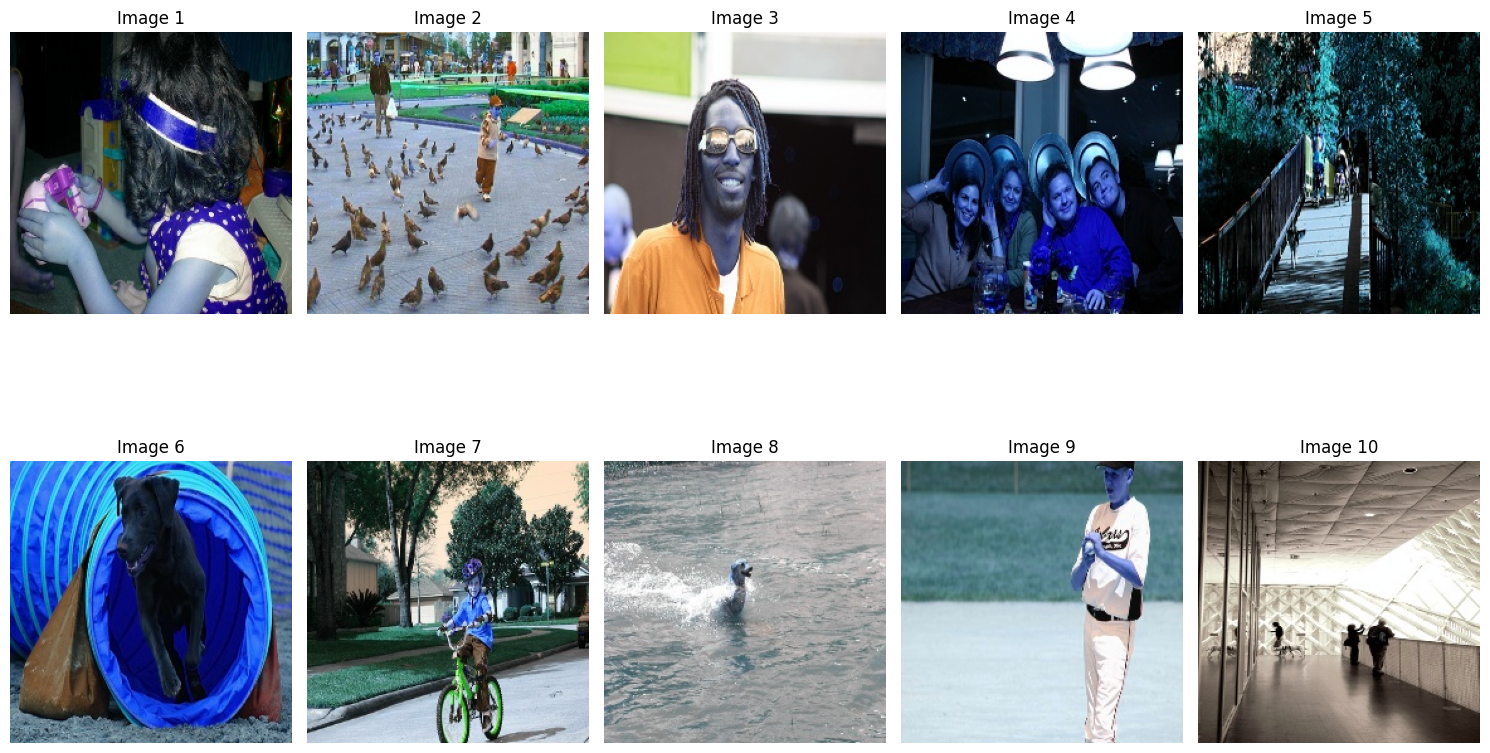

In [ ]:
# Call the function to display images
display_images(ready_folder, num_images=10)

In [ ]:
labels_file = os.path.join(path, found_files[0])

In [ ]:
for line in open(labels_file, 'r'):
    print(line)

Streaming output truncated to the last 5000 lines.
515755283_8f890b3207.jpg,A police officer posing with two army officers beside his motorcycle .

515755283_8f890b3207.jpg,There are three policemen and a police motorcycle .

515755283_8f890b3207.jpg,Three police officers next to a police motorcycle .

515755283_8f890b3207.jpg,Three police officers pose with a motorcycle .

515755283_8f890b3207.jpg,Two men in red berets pose with a motorcycle cop .

515797344_4ae75cb9b1.jpg,Men walking on city street with a yellow bus and two FedEx vehicles in the background .

515797344_4ae75cb9b1.jpg,some men crossing the street in a busy city

515797344_4ae75cb9b1.jpg,"Three men crossing a street , with trucks in the background ."

515797344_4ae75cb9b1.jpg,Three men cross the street in front of a yellow truck .

515797344_4ae75cb9b1.jpg,Three men walking on a city street in front of a yellow bus and two FedEx trucks .

516214924_c2a4364cb3.jpg,A brown dog chews on an orange ball .

516214924_c2a4364

In [ ]:
# Open the file and process lines
raw_captions = []
with open(labels_file, 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing spaces
        parts = line.split(".jpg,", 1)  # Split at first ".jpg,"
        if len(parts) == 2:  # Ensure split was successful
            raw_captions.append([parts[0] + ".jpg", parts[1].strip()])  # Add ".jpg" back and strip extra spaces

In [ ]:
# Create DataFrame with two columns
raw_captions = pd.DataFrame(raw_captions, columns=['image_name', 'caption'])

In [ ]:
raw_captions.head()

image_name  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
prnt= for

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
Name: caption, dtype: object
